This data set logs all the issues captured by the Improve Detroit mobile app that's used in many of the city's departments. 

The goal of this notebook is to explore, and motivate the different questions we can and should ask based on the data.

In [1]:
# Import useful packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# Load the data and do some initial exploration

In [2]:
data = pd.read_csv('./Improve_Detroit_Issues.csv', header = 0)
data.head()

C:\Users\Victor Le\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,X,Y,id,status,request_type_title,description,web_url,report_method,priority_code,created_at,...,closed_at,reopened_at,updated_at,days_to_close,canonical_issue_id,address,neighborhood,council_district,oid,geom
0,-82.922541,42.399903,9630294,Acknowledged,Investigate Blocked Basin Street,storm water backflow into my basement,https://seeclickfix.com/issues/9630294,direct,2,2021/04/01 06:05:38+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 06:05:45+00,NaN,NaN,"3981 Guilford St Detroit, MI 48224, USA",NaN,NaN,1,NaN
1,-83.232881,42.333398,9629814,Acknowledged,Investigate Blocked Basin Street,Sewer Water has been pouring into my basement ...,https://seeclickfix.com/issues/9629814,direct,2,2021/04/01 04:50:04+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 04:50:28+00,NaN,NaN,"6073 Auburn St Detroit MI 48228, United States",NaN,NaN,2,NaN
2,-83.107571,42.436438,9629750,Open,Traffic Complaints,Person lighting fireworks and loud explosives ...,https://seeclickfix.com/issues/9629750,direct,2,2021/04/01 04:20:51+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 04:20:51+00,NaN,NaN,"400 Annin St Detroit MI 48203, United States",NaN,NaN,3,NaN
3,NaN,NaN,9629710,Open,Abandoned Vehicle,Redacted,https://seeclickfix.com/issues/9629710,direct,2,2021/04/01 04:00:45+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 04:00:47+00,NaN,NaN,Redacted,NaN,NaN,4,NaN
4,-83.223464,42.346134,9629705,Open,Reboard House Request,This home is burnt down. Dumping is starting ...,https://seeclickfix.com/issues/9629705,direct,2,2021/04/01 03:58:55+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 03:59:01+00,NaN,NaN,"7395 Brace St Detroit, MI 48228, USA",NaN,NaN,5,NaN


## Visualizations

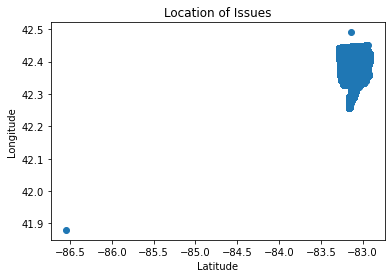

In [3]:
# Let's make a scatter plot of every issue reported to get a sense of the density of reports 
x = data['X']
y = data['Y']

plt.scatter(x,y)
plt.title('Location of Issues')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

Seems like there's a huge outlier, an entry that had its input reversed. Let's remove that and try again.

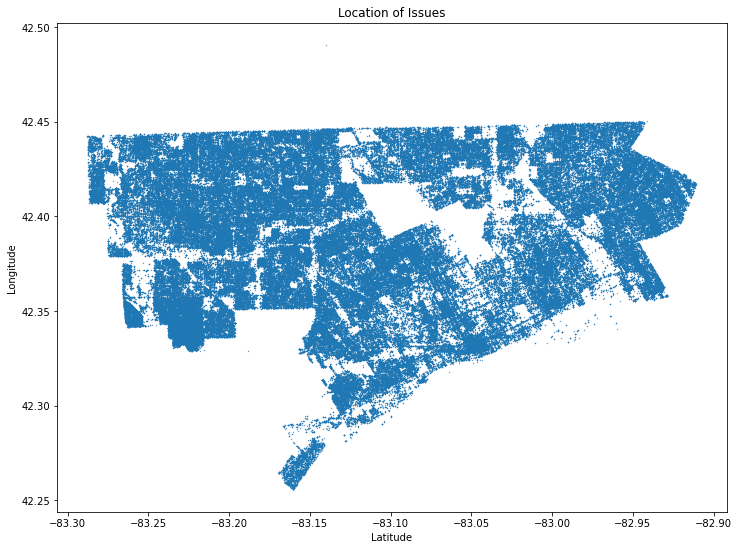

In [4]:
valid = (data['X'] > -85) | (data['Y'] > 42)

x = data['X'][valid]
y = data['Y'][valid]

plt.figure(figsize=(12, 9))
plt.scatter(x,y, s=0.1)
plt.title('Location of Issues')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

Now that looks like Detroit! Though, it's not entirely clear visually that issues are reported more often than in other parts of the city. Let's see if there's a difference in which issues get closed by location.

['Acknowledged' 'Open' 'Closed' 'Archived']


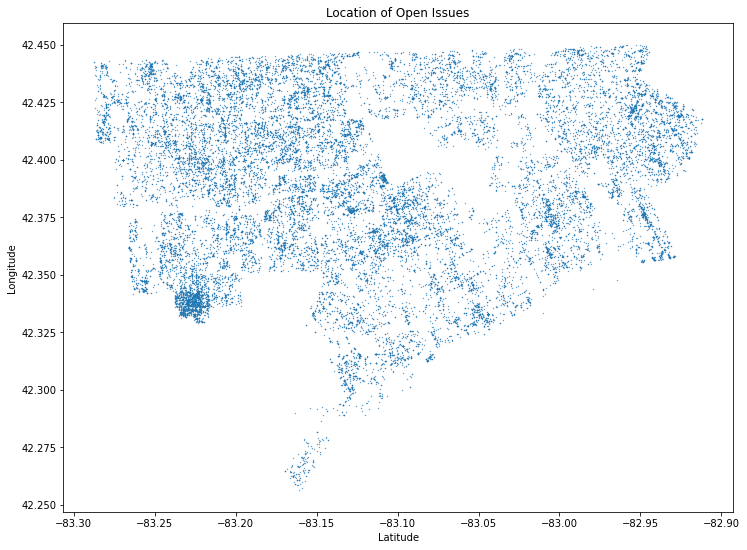

In [9]:
print(data['status'].unique()) # what statuses are assigned to issues?

open_issues = (data['status'] == 'Open')

plt.figure(figsize=(12, 9))
plt.scatter(x[open_issues],y[open_issues], s=0.1)
plt.title('Location of Open Issues')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

It seems like the lower left corner of Detroit has the most issues still opened. Does this coincide with the priority code?

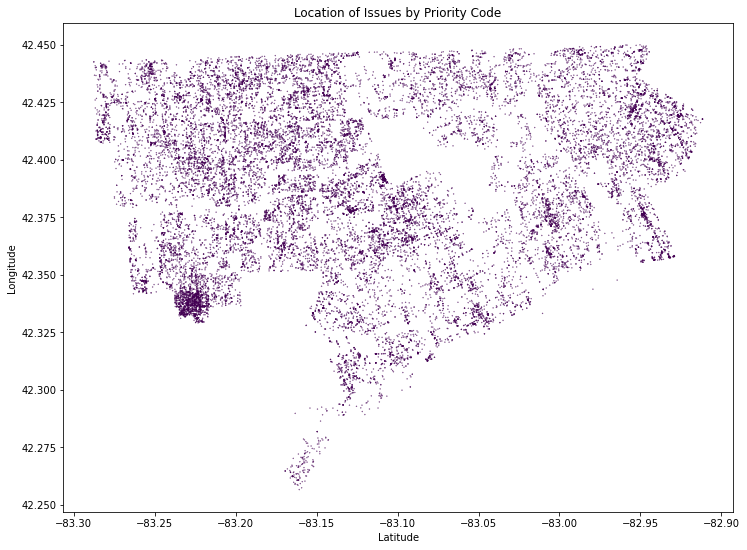

In [8]:
priority = data['priority_code'][valid]

plt.figure(figsize=(12, 9))
plt.scatter(x[open_issues],y[open_issues], s=0.1, c=priority[open_issues], cmap = 'viridis')
plt.title('Location of Issues by Priority Code')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

That didn't get us anywhere either. It seems like there is actually only one priority code in the dataset, which doesn't help us very much. It does seem that there is a standardized way to classify the requests. Let's see what that looks like on the map.

# Request Types

In [18]:
request_types = data['request_type_title'].value_counts()
print(len(request_types))
print(request_types)

54
DPW - Debris Removal - DPW USE ONLY                           95272
Illegal Dump Sites                                            67797
Curbside Solid Waste Issue                                    53866
Abandoned Vehicle                                             43928
DPW - Other environmental - DPW USE ONLY                      40097
Tree Issue                                                    29647
Curbside - DPW ONLY                                           29111
Potholes                                                      26233
Traffic Sign Issue                                            15991
Blocked Catch Basin                                           14894
Rodent Extermination                                           9925
Rodent Extermination - BSEED Only                              8551
Running Water in a Home or Building                            6926
Investigate Water Main Break                                   6575
Water Main Break                             

Evidently, it seems like there some city departments that work on specific issues (e.g., Department of Public Works, DPW). I will assume that these issues are not reported by regular citizens. Let's remove these types of issues to see what citizens are normally reporting on.

## Remove issues reported by city departments

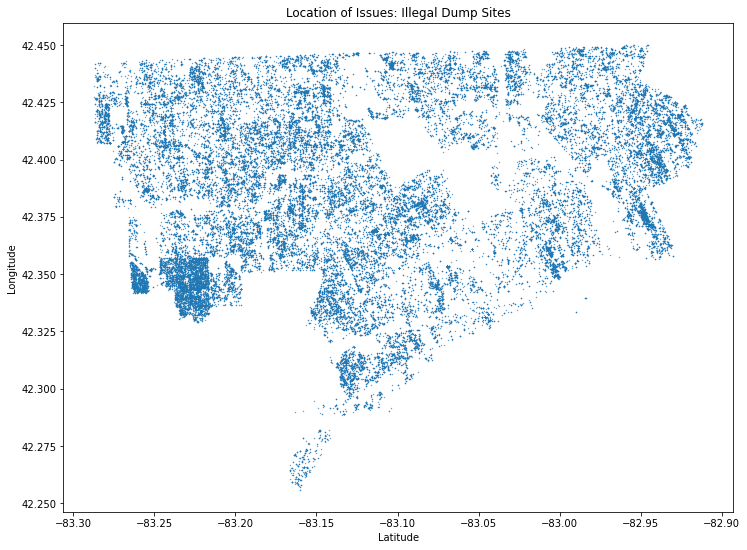

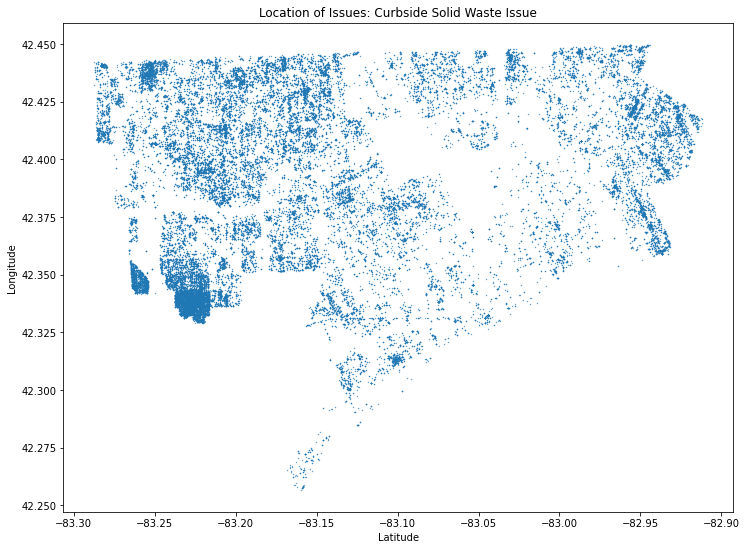

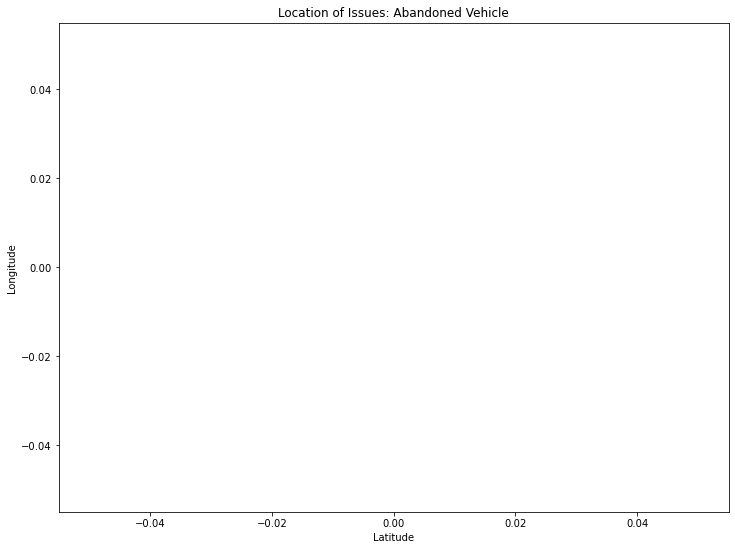

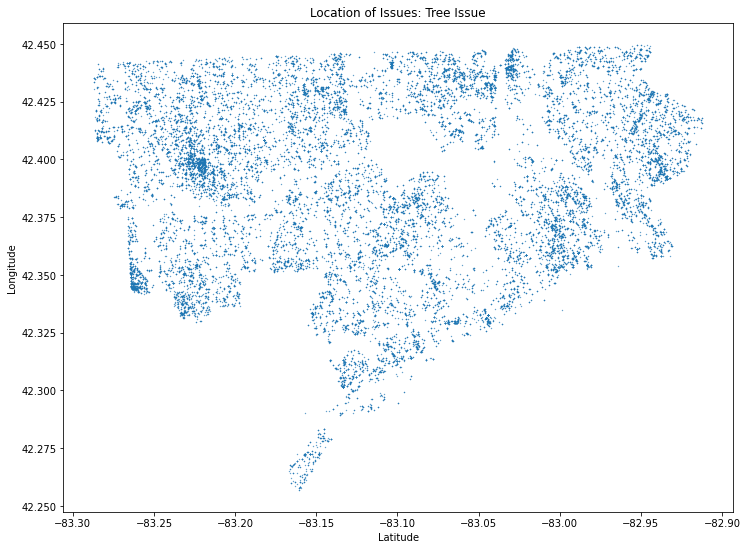

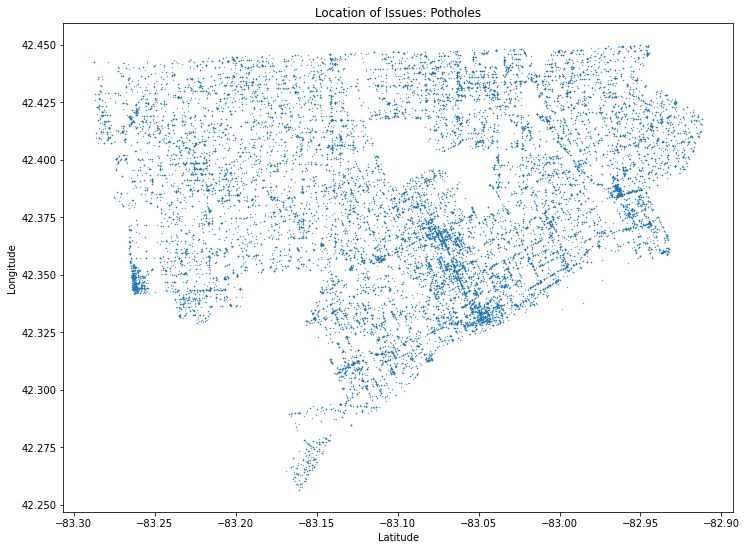

In [49]:
citizenData = data[~data['request_type_title'].str.contains('DPW|BSEED|GSD')] # use regex property of dataframes
popularIssues = citizenData['request_type_title'].value_counts()
# print(popularIssues)
validCitizen = (citizenData['X'] > -85) | (citizenData['Y'] > 42)

# choose which issue here
choice = 0
issue = citizenData['request_type_title'] == popularIssues.index[choice]

# let's plot the locations of the most popular issue
plt.figure(figsize = (12,9))
plt.scatter(citizenData['X'][validCitizen & issue],citizenData['Y'][validCitizen & issue], s=0.1)
plt.title('Location of Issues: {}'.format(popularIssues.index[choice]))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

# choose which issue here
choice = 1
issue = citizenData['request_type_title'] == popularIssues.index[choice]

# let's plot the locations of the most popular issue
plt.figure(figsize = (12,9))
plt.scatter(citizenData['X'][validCitizen & issue],citizenData['Y'][validCitizen & issue], s=0.1)
plt.title('Location of Issues: {}'.format(popularIssues.index[choice]))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

# choose which issue here
choice = 2
issue = citizenData['request_type_title'] == popularIssues.index[choice]

# let's plot the locations of the most popular issue
plt.figure(figsize = (12,9))
plt.scatter(citizenData['X'][validCitizen & issue],citizenData['Y'][validCitizen & issue], s=0.1)
plt.title('Location of Issues: {}'.format(popularIssues.index[choice]))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

# choose which issue here
choice = 3
issue = citizenData['request_type_title'] == popularIssues.index[choice]

# let's plot the locations of the most popular issue
plt.figure(figsize = (12,9))
plt.scatter(citizenData['X'][validCitizen & issue],citizenData['Y'][validCitizen & issue], s=0.1)
plt.title('Location of Issues: {}'.format(popularIssues.index[choice]))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

# choose which issue here
choice = 4
issue = citizenData['request_type_title'] == popularIssues.index[choice]

# let's plot the locations of the most popular issue
plt.figure(figsize = (12,9))
plt.scatter(citizenData['X'][validCitizen & issue],citizenData['Y'][validCitizen & issue], s=0.1)
plt.title('Location of Issues: {}'.format(popularIssues.index[choice]))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

Some insights:
* The top two most common issues __Illegal Dump Sites__ and __Curbside Solid Waste Issue__ are densely packed into the lower left corner, as identified from before. My first assumption is that this might be a densely urban area of Detroit. 
* There is NO location data for __Abandoned Vehicles__, and it's unclear why that would be.
* The fact that _Tree Issues_ are not showing the same geospatial density confirms the idea that the lower left corner of Detroit is a lot more densely urban and packed. 
* Oddly enough, _Potholes_ do not coincide with the lower left corner either, which may be a result of fewer cars driving through. In fact, the potholes seem to be more commonly reported in the center right portion of Detroit, which is most likely their Main Street area where cars tend to drive through. 

## Looking ONLY at city department-reported issues

### Let's look at the most popular issue from each department

DPW - Debris Removal - DPW USE ONLY         95272
DPW - Other environmental - DPW USE ONLY    40097
Curbside - DPW ONLY                         29111
Rodent Extermination - BSEED Only            8551
Illegal Signs - GSD Only                      681
Alley Grading - DPW Use Only                  149
Alley Debris – GSD ONLY                        54
Name: request_type_title, dtype: int64


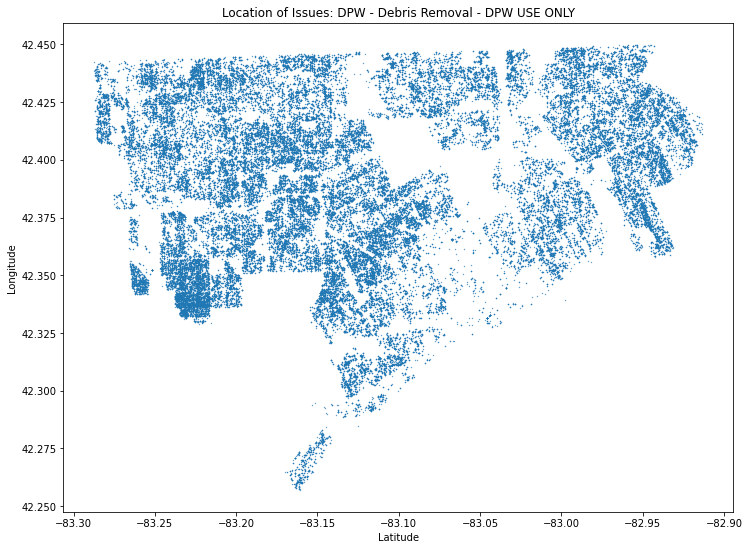

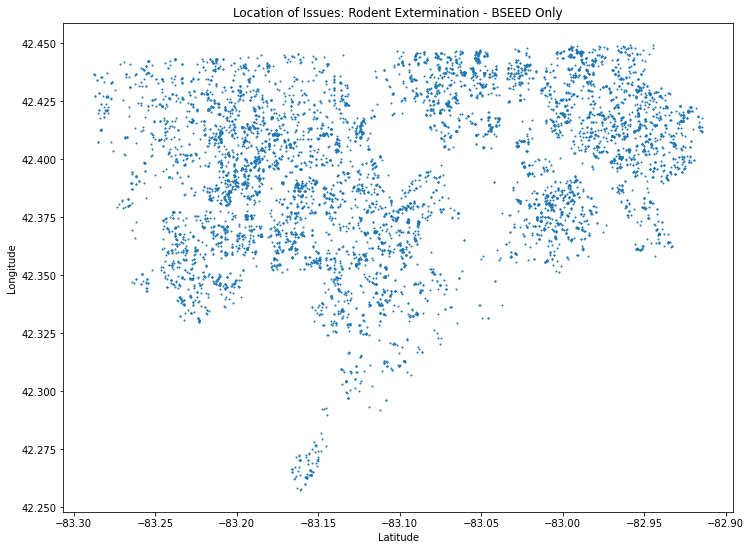

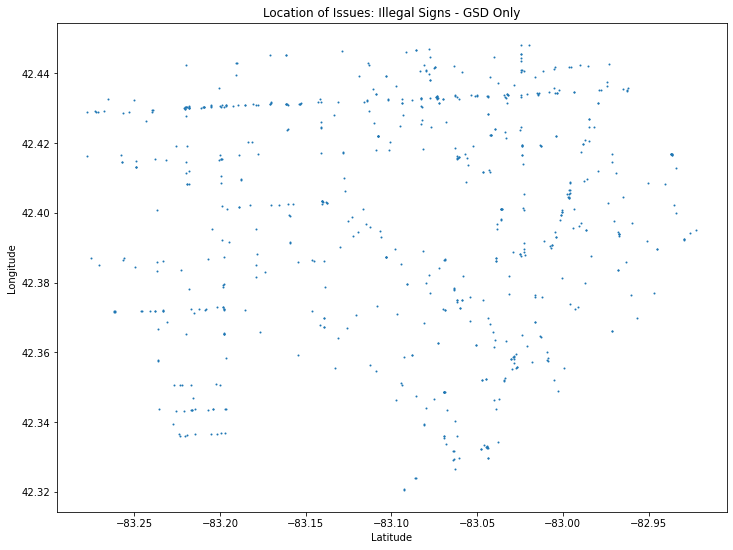

In [54]:
departmentData = data[data['request_type_title'].str.contains('DPW|BSEED|GSD')] # use regex property of dataframes
popularIssues = departmentData['request_type_title'].value_counts()
print(popularIssues)
validDepartment = (departmentData['X'] > -85) | (departmentData['Y'] > 42)

# choose which issue here
choice = 0
issue = departmentData['request_type_title'] == popularIssues.index[choice]

# let's plot the locations of the most popular issue
plt.figure(figsize = (12,9))
plt.scatter(departmentData['X'][validDepartment & issue], departmentData['Y'][validDepartment & issue], s=0.1)
plt.title('Location of Issues: {}'.format(popularIssues.index[choice]))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

# choose which issue here
choice = 3
issue = departmentData['request_type_title'] == popularIssues.index[choice]

# let's plot the locations of the most popular issue
plt.figure(figsize = (12,9))
plt.scatter(departmentData['X'][validDepartment & issue], departmentData['Y'][validDepartment & issue], s=1)
plt.title('Location of Issues: {}'.format(popularIssues.index[choice]))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

# choose which issue here
choice = 4
issue = departmentData['request_type_title'] == popularIssues.index[choice]

# let's plot the locations of the most popular issue
plt.figure(figsize = (12,9))
plt.scatter(departmentData['X'][validDepartment & issue], departmentData['Y'][validDepartment & issue], s=1)
plt.title('Location of Issues: {}'.format(popularIssues.index[choice]))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()



Some insights:
* __DPW__ displays a similar density in the lower left corner. However, there is a peculiar sparseness in the Main Street area. Perhaps that is handled by different departments, or debris is removed from there often by others?
* Unfortunately, the remaining departments are not reported often enough, and seem to be scattered uniformly.
* However, it's confirming to see that the illegal signs are almost aligned, which would be fitting with the roads. 

# Where does that leave us?

Evidently, there is still a lot more to explore. One of the main insights here is that the most common issues are reported in the lower left corner of Detroit. Consequently, a majority of the issues still left Open are found in that area. More exploration needs to be done to determine whether that is on part of the department or the citizens reporting it. Something interesting to look at would be the time it takes to close issues, and the shortest times by neighboorhood.